In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

sample_submission.csv
test.csv
train.csv



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# Loading the training data
train_df = pd.read_csv('../input/train.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# get all columns
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
# Lets get the description of target
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

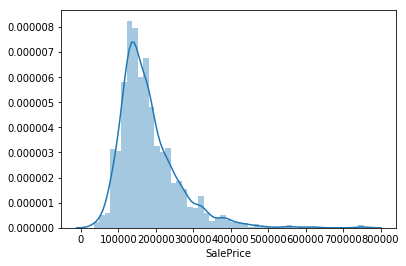

In [7]:
# Histogram
sns.distplot(train_df['SalePrice']);

Sales prices are distributed normally and are positively skewed.

In [8]:
# Skewness and kurtosis
print("Skewness: ", train_df['SalePrice'].skew())
print("Kurtosis: ", train_df['SalePrice'].kurt())

Skewness:  1.88287575977
Kurtosis:  6.53628186006


Our target variable distribution is highly skewed towards right as the value for skewness is more than 1.
Generally, 
If -1/2\<skewness\<1/2, then the data is symmetric, or
If -1\<skewness\<1, then the data is moderately skewed, or
If skewness\<-1 OR skewness\>1, then the data is highly skewed.
Also, the sign (+/-) tells whether the data is positevely or negatively skewed

Also, the data is Leptokurtic as kurtosis >> 0
Generally,
If kurtosis\>0, then the data is Leptokurtic and more peaked compared to normal distribution AND there's less variability, or
If kurtosis\<0, then the data is Platykurtic and less peaked compared to normal distribution AND there's more variability, or
If kurtosis=0, then the data is Mesokurtic and normal.

## Proceeding with the variables
As per some analysis and common sense, the following variables seem to be important in having considerable effect on the dependent variable.  
1. OverallQual - Overall material and finish quality
2. YearBuilt - Original construction date  
3. TotalBsmtSF - Total square feet of basement area  
4. GrLivArea -  Above grade (ground) living area square feet

## Relationship with numeric variables

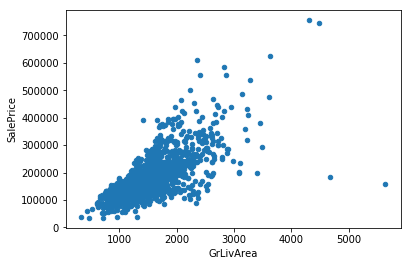

In [9]:
# scatter plot - GrLivArea vs SalePrice
data = pd.concat([train_df['SalePrice'], train_df['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice');

There seems to be a linear relationship between GrLivArea and SalePrice

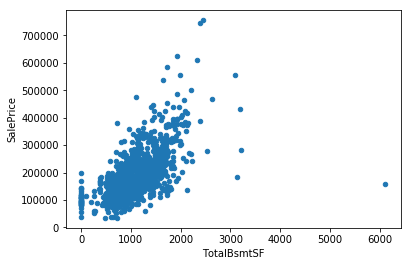

In [10]:
# scatter plot - TotalBsmtSF vs SalePrice
train_df.plot.scatter(x='TotalBsmtSF', y='SalePrice');

Looks like there's a linear relationship.

## Relationship with categorical variables

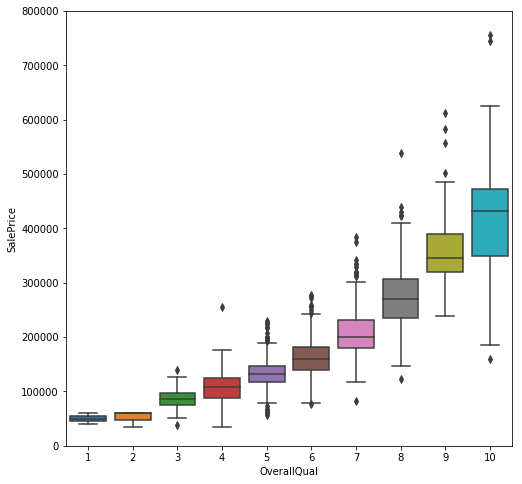

In [20]:
# Boxplot OverallQual vs SalePrice
var = 'OverallQual'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize= (8, 8))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000);

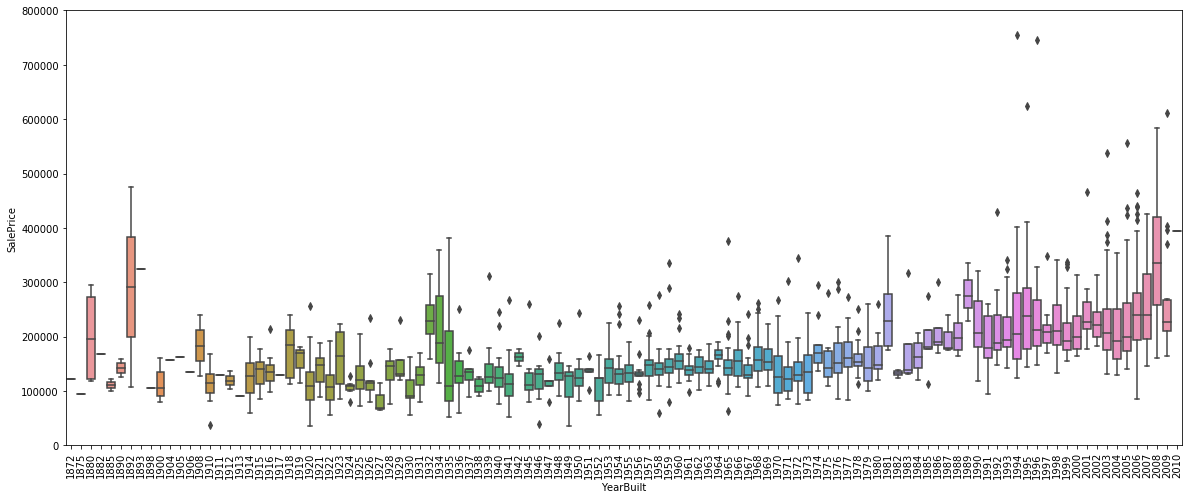

In [23]:
# YearBuilt vs SalePrice
var = 'YearBuilt'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 8))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

We could've thought the same that prices for new houses would be more than that for the old ones.

## Summary
1. Both 'GrLivArea' and 'TotalBsmtSF' seem to have a positive linear relationship with the dependent variable - 'SalePrice'. 'TotalBsmtSF', in particular, seems to have high slope.  
2. Both 'OverallQual' and 'YearBuilt' seem to have relationship with 'SalePrice'. The relationship seems to be stronger in case of 'OverallQual' as, when it increases, the 'SalePrice' also increase.  
  


### Correlation Matrix (hearmap style)

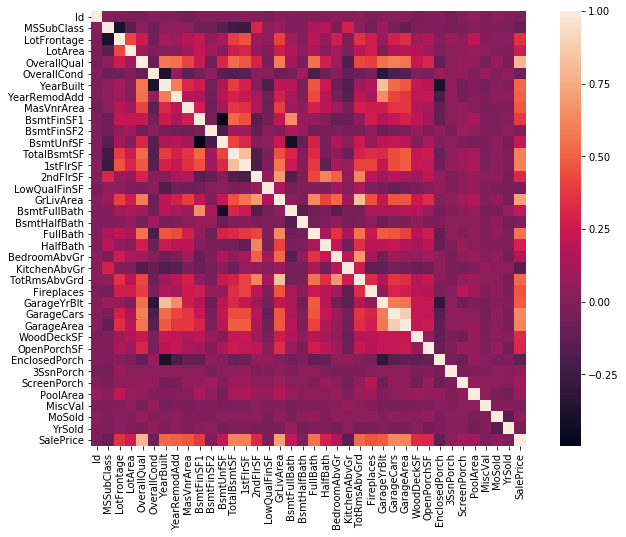

In [34]:
# Correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corrmat, square=True);

That's a great way to visualize how strong variable pairs have correlations.  
'TotalBsmtSF' and '1stFlrSF' seem to be highly correlated. Likewise, we can see that there are other pairs also that seem to have more correlation as compared to others. Srong ccorrelations can indicate multicollinearity. It's one place where we should not go. This is mainly because using any one will get our job done. We need not use the other as it is "redundant" in explaining the dependent variable (as explained by the correlation matrix). We should keep this thing in mind.  
Also, as thought initially, the variables  'GrLivArea', 'TotalBsmtSF', and 'OverallQual' seem to have a nice correlation with 'SalePrice'. However, there are other variables too, that seem to have good amount of correlation with 'SalePrice'.

### 'SalePrice' correlation matrix (zoomed heatmap style)

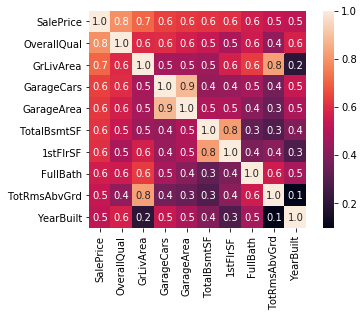

In [93]:
# SalePrice correlation Matrix
k = 10 # number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
#cm = np.corrcoef(train_df[cols])
cm = np.corrcoef(train_df[cols].values, rowvar=False)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
           annot_kws={'size':10}, yticklabels=cols.values, 
            xticklabels=cols.values)
plt.show();

1. SalePrice seem to be highly related with OverallQual and GrLivArea and moderately related with GarageCars, GarageArea, TotalBsmtSF and 1stFlrSF.  
2. GarageCars and GarageArea are highly related to each other. Its hard to distinguish them. So, we'll keep only one(which has better correlation with SaleProce) and get rid of the other. Let's keep GarageCars.  
3. Same is the case with TotalBsmtSF and 1stFlrSF. Let's keep TotalBsmtSF.  
4. Again, TotRmsAbvGrd and GrLivArea exhibit high correlation. Let's keep GrLivArea, as it has more correlation with SalePrice